## Classical Molecular Dynamics

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from jcp_rgs_md import *

In [93]:
def fs_time(au_time):
    return 0.0241888 * au_time

def GetPairNeighborlist(Z, R_ix, cutoff):
    """
    Given XYZ, get Neighborlist from Cutoff, i.e. i & j (with distance R)
    Given Z, get types of pair-interactions, i.e. P, and ZZ corresponding atom types
    """
    
    ####### Initial Complete Pair-wise Distance Matrix
    onez = np.ones(R_ix.shape[0], dtype=np.float32)
    RR  = (np.einsum('jx, i -> ijx', R_ix, onez) - np.einsum('ix, j -> ijx', R_ix, onez))
    RR  = np.einsum("ijx -> ij", RR**2)**(0.5)
    RR += 2*cutoff*np.eye(len(RR), dtype=np.float32)
    
    ## i and j which are less than the cutoff
    i, j = np.where(RR < cutoff)
    
    ## find all types of pair interactions
    ZZ_unique, pairtypes = np.unique( np.array([Z[i], Z[j]]).T , axis=0, return_inverse=True)
    pairtypes = pairtypes.astype(np.int8) ## we want an array of {0,1,2...N} for each pair-type!
    
    ## finds for each atom, the range of values in P
    Atoms_over_Pairs = np.where( np.diff(i) == 1)[0]
    Atoms_over_Pairs = np.append(Atoms_over_Pairs, [len(i)-1]).astype(np.int32)
    
    return i, j, RR[i,j], pairtypes, ZZ_unique, Atoms_over_Pairs

def Partition_PairTypes(R_ix, i, j, P):
    """ Given PairTypes partition Neighborlist {i,j} into list i_pair, j_pair 
    We need a new AR for each pair!!!
    """
    
    for pairtype in range(len(ZZ)):
        pair = np.where(P == pairtype)[0]
        i_pair = i[pair]
        j_pair = j[pair]
        
        ## finds for each atom, the range of values in P
        Atoms_over_Pairs = np.where( np.diff(i_pair) == 1)[0]
        Atoms_over_Pairs = np.append(Atoms_over_Pairs, [len(i_pair)-1]).astype(np.int32)
        
        ## calculate basis vectors for pair
        basis_vectors = R_ix[i_pair] - R_ix[j_pair]
        distances     = (np.einsum("Px -> P", basis_vectors**2)**(0.5))
        
        ## calculate forces over this pair-list
        force_mag     = np.interp(distances, x, LJf_Ar[pairtype]) ## LJE_Ar LJf_Ar   LJf_2 [pairtype]
        forces        = np.einsum("P, Px, P -> Px", force_mag, basis_vectors, 1/distances)
        
        ## get f_ix
        cumforce      = np.cumsum(forces, axis=0)[AR,:]
        cumforce2     = 1.0*cumforce
        cumforce2[0]  = np.zeros(3)
        f_ix          = cumforce - cumforce2
        
        ## get Potential Energy
        PE            = np.einsum("P -> ", np.interp(distances, x, LJE_Ar[pairtype])) ### LJE_Ar  LJE_2[pairtype]
    
    return f_ix, PE

def GetPairForcez(f_IR, R_ix, i, j, P, AR):
    """
    Given:  Neighborlist Information {i,j,P,AR}
            Locations (R_ix)
            Force Function (f_IR)
    Get:
            Force on Atoms (f_ix)
    """
    
    basis_vectors = R_ix[i] - R_ix[j] ## basis vectors
    distances     = (np.einsum("Px -> P", basis_vectors**2)**(0.5))

    R_tab     = (10*distances).astype(np.int16)
    force_mag = f_IR[P, R_tab]
    forces    = np.einsum("P, Px, P -> Px", force_mag, basis_vectors, 1/distances)
    cumforce  = np.cumsum(forces, axis=0)
    f_ix      = cumforce[AR,:] - np.roll(cumforce[AR,:], 0)
    
    return f_ix

def GetPairForces(x, LJf_Ar, R_ix, i, j, AR):
    """
    Given:  Neighborlist Information {i,j,P,AR}
            Locations (R_ix)
            Force Function (f_IR)
    Get:
            Force on Atoms (f_ix)
    """
    
    #### ?? 1/1/22 partition forces atom-pairs based on their interaction!
    #### for each partition we net a f_ix, add these together!
    #### for each partition we have a AR (that divides cumforces)
    
    #### calculate forces
    basis_vectors = R_ix[i] - R_ix[j]
    distances     = (np.einsum("Px -> P", basis_vectors**2)**(0.5))
    force_mag     = np.interp(distances, x, LJf_Ar)
    forces        = np.einsum("P, Px, P -> Px", force_mag, basis_vectors, 1/distances)
    
    cumforce      = np.cumsum(forces, axis=0)[AR,:]
    cumforce2     = 1.0*cumforce
    cumforce2[0]  = np.zeros(3)
    f_ix          = cumforce - cumforce2
    
    PE            = np.einsum("P -> ", np.interp(distances, x, LJE_Ar))
    
    return f_ix, PE

### define a class for tablulated force (atom pair + excited state + distance)
### define a class for neighborist (given a neighborlist trim it)
#R_potential = np.arange(0.1, 15, 0.01)
#f_IR        = np.array([np.exp(- 0.2 * R_potential)])

#i, j, R, P, ZZ, AR = GetPairNeighborlist(Z, R_ix, Bohr(10)) ## P are pair-types
#f_ix = GetPairForcez(f_IR, R_ix, i, j, P, AR)

#print( f_ix.shape )
#print( np.einsum("ix -> ", f_ix  ) )

In [94]:
number_of_neighbors_per_atom_i = np.append(AR[0], np.diff(AR))
bulk_atoms = np.where( number_of_neighbors_per_atom_i == np.max(number_of_neighbors_per_atom_i) )[0]
#np.max(number_of_neighbors_per_atom_i)
bulk_atoms

pair = np.where(P == 0)[0]
i_pair = i[pair]
i_pair

array([   0,    0,    0, ..., 4630, 4630, 4630])

## Tabluated Potential

##### Here we define a potential on ~10^4 array, probably defined on må.
##### If greater than the amount, then the interaction is 0.
##### this potential must be sampleds and interpolated!!! forces = np.interp(distances, xp, fp)

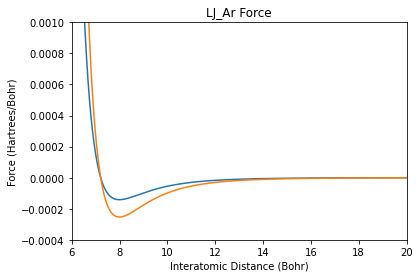

In [80]:
## http://www.sklogwiki.org/SklogWiki/index.php/Argon
σ = 6.42507 ## 0.34 nm [Rahman 1964] 
ε = 3.80e-4  ## 120 K  [Rahman 1964]

x       = np.arange(2.0, 20, 0.001)
LJE_Ar  =  4*ε*((σ/x)**12 - (σ/x)**6)
LJf_Ar  = 24*ε*(σ**6)*(2*σ**6/(x**13) - 1/(x**7))

ε = 6.80e-4
LJE_Ar2 =  4*ε*((σ/x)**12 - (σ/x)**6)
LJf_Ar2 = 24*ε*(σ**6)*(2*σ**6/(x**13) - 1/(x**7))

LJf_2 = np.array([LJf_Ar, LJf_Ar2])
LJE_2 = np.array([LJE_Ar, LJE_Ar2])

plt.plot(x, LJf_2[0], label="LJ_Ar Force")
plt.plot(x, LJf_2[1], label="LJ_Ar2 Force")
plt.title("LJ_Ar Force")
plt.xlabel("Interatomic Distance (Bohr)")
plt.ylabel("Force (Hartrees/Bohr)")
plt.ylim([-0.0004,0.001])
plt.xlim([6.0,20])
plt.show()

In [131]:
### Enviroment Inputs
Temp    = 50 #/315774.64
T       = 1.01e4 ### total duration in fs
dt      = 2.5 ### Time Step in fs
Z, R_ix = xyz_reader('Ar_1000.xyz') ### XYZ file. R_ix in Ångströms
γ       = 0.0000 # Langevin Coupling (in a.u.)
Cutoff  = 10 # in Ångströms

i, j, R, P, ZZ, AR = GetPairNeighborlist(Z, R_ix, Bohr(10)) ## P are pair-types

mass    = getMass(Z)
R_ix    = Bohr(R_ix)
v_ix    = 0.0*R_ix
a_ix    = 0.0*R_ix

dt    = 100     ## a.u. time
T_sim = 100000  ## a.u. time
time_array = np.arange(0, T_sim, dt) ## in au
E_t = np.zeros(time_array.shape)
for t, element in tqdm(enumerate(time_array)):
    ### Langevin Thermostat
    ξ_ix  = np.random.normal(0, 1, (len(R_ix), 3))
    θ_ix  = np.random.normal(0, 1, (len(R_ix), 3))
    C_ix  = 0.5 * dt * dt * (a_ix - γ*v_ix)
    C_ix += 0.5 * (dt**(1.5)) * np.einsum("i, ix -> ix", np.sqrt(2*Temp*γ/mass), ξ_ix + θ_ix/(np.sqrt(3)) )
    R_ix += v_ix * dt + C_ix ## 0.5 * a_ix * dt * dt
    
    #### calculate forces
    f_ix, PE  = GetPairForces(x, LJf_Ar, R_ix, i, j, AR)
    #f_ix, PE  = Partition_PairTypes(R_ix, i, j, P)
    A_ix   = np.einsum("ix, i -> ix", f_ix, 1/mass)
    E_t[t] = np.einsum("i, ix -> ", 0.5*mass, v_ix**2) + PE
    
    v_ix += 0.5 * (a_ix + A_ix) * dt - γ * v_ix * dt + np.einsum("ix, i -> ix", ξ_ix, np.sqrt(2*Temp*γ*dt/mass)) + γ * C_ix 
    
    #### Acceleration Reset
    a_ix = A_ix

1000it [03:03,  5.44it/s]


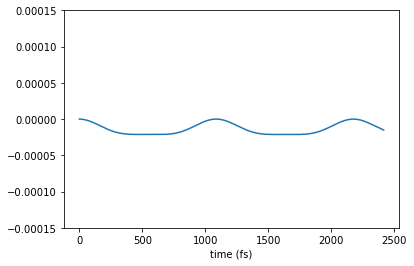

In [132]:
ε = 1.5e-4
E_t - E_t[0]
plt.plot(fs_time(time_array), E_t - E_t[0])
plt.ylim([-ε, ε])
plt.xlabel("time (fs)")
plt.show()

In [129]:
ξ_ix = np.random.normal(0, 1, (len(R_ix),3))

- γ * v_ix * dt + np.einsum("ix, i -> ix", ξ_ix, np.sqrt(2*Temp*γ*dt/mass)) + γ * C_ix

array([[-0.0005643 , -0.00084843, -0.00088311],
       [-0.00364832,  0.00048354,  0.0071209 ],
       [-0.00266859, -0.00306915,  0.0036224 ],
       ...,
       [-0.00198972,  0.0001619 ,  0.00387263],
       [ 0.00104212,  0.00199385,  0.00518201],
       [-0.00129602,  0.00932722,  0.00556959]])